In [4]:
import numpy as np
import pandas as pd
import json
from sklearn import preprocessing

In [5]:
truth_df = pd.DataFrame(columns=['id','truthClass'])
with open('data/truth.jsonl') as data:
    for labelobj in data:
        truth = json.loads(labelobj)
        truthlabel = {'id': truth['id'], 'truthClass': truth['truthClass']}
        truth_df = truth_df.append(truthlabel, ignore_index = True)
truth_df.head()   

,id,truthClass
0,858464162594172928,clickbait
1,858462320779026433,no-clickbait
2,858460992073863168,no-clickbait
3,858459539296980995,no-clickbait
4,858455355948384257,no-clickbait


In [6]:
instances_df = pd.DataFrame(columns=['id','postText'])
with open('data/instances.jsonl') as data:
	for instanceobj in data:
		instance = json.loads(instanceobj)
		instancerow = {'id': instance['id'], 'postText': instance['postText']}
		instances_df = instances_df.append(instancerow, ignore_index=True)
instances_df.head()

,id,postText
0,858462320779026433,[UK’s response to modern slavery leaving victi...
1,858421020331560960,[this is good]
2,858368123753435136,"[The ""forgotten"" Trump roast: Relive his bruta..."
3,858323428260139008,[Meet the happiest #dog in the world!]
4,858283602626347008,[Tokyo's subway is shut down amid fears over a...


In [7]:
dataset = instances_df.join(truth_df.set_index('id'), on='id')
for i in range(len(dataset)):
    dataset['postText'].values[i] = dataset['postText'].values[i][0]
dataset['postText'].dropna(inplace=True)
dataset.head()

,id,postText,truthClass
0,858462320779026433,UK’s response to modern slavery leaving victim...,no-clickbait
1,858421020331560960,this is good,clickbait
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,858323428260139008,Meet the happiest #dog in the world!,clickbait
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [8]:
def toBinary(truthClass):
    if truthClass == 'no-clickbait':
        return 0
    else:
        return 1
dataset['truthClass'] = dataset['truthClass'].apply(toBinary)
dataset.head()

,id,postText,truthClass
0,858462320779026433,UK’s response to modern slavery leaving victim...,0
1,858421020331560960,this is good,1
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",0
3,858323428260139008,Meet the happiest #dog in the world!,1
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,0


In [9]:
import string
import re
def cleanText(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text) 
    return text
dataset['cleanPostText'] = dataset['postText'].apply(cleanText)
dataset.head()

,id,postText,truthClass,cleanPostText
0,858462320779026433,UK’s response to modern slavery leaving victim...,0,uks response to modern slavery leaving victims...
1,858421020331560960,this is good,1,this is good
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",0,the forgotten trump roast relive his brutal 20...
3,858323428260139008,Meet the happiest #dog in the world!,1,meet the happiest dog in the world
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,0,tokyos subway is shut down amid fears over an ...


In [23]:
def count_punc(postText):
    return len(postText)
dataset['numOfPunctuation'] =  dataset['postText'].apply(count_punc) - dataset['cleanPostText'].apply(count_punc)
dataset.drop(dataset[dataset['numOfPunctuation']>15].index , inplace = True)
numOfPunctuation = dataset[['numOfPunctuation']].values
min_max_scaler = preprocessing.MinMaxScaler()
dataset['numOfPunctuationNorm'] = min_max_scaler.fit_transform(numOfPunctuation)
dataset.head()

,id,postText,truthClass,cleanPostText,numOfPunctuation,numOfPunctuationNorm
0,858462320779026433,UK’s response to modern slavery leaving victim...,0,uks response to modern slavery leaving victims...,1,0.066667
1,858421020331560960,this is good,1,this is good,0,0.000000
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",0,the forgotten trump roast relive his brutal 20...,3,0.200000
3,858323428260139008,Meet the happiest #dog in the world!,1,meet the happiest dog in the world,2,0.133333
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,0,tokyos subway is shut down amid fears over an ...,1,0.066667


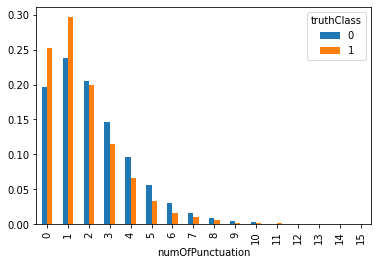

In [29]:
import matplotlib.pyplot as plt
df1 = dataset.groupby('numOfPunctuation')['truthClass'].value_counts().unstack()
df1 = df1.divide(df1.sum(axis=0), axis=1)
df1.plot(kind = 'bar', stacked = False)
plt.show()

In [31]:
dataset = dataset.drop(['postText'],axis=1)
dataset = dataset.rename(columns = {'cleanPostText': 'postText'}, inplace = False)
dataset.head()

,id,truthClass,postText,numOfPunctuation,numOfPunctuationNorm
0,858462320779026433,0,uks response to modern slavery leaving victims...,1,0.066667
1,858421020331560960,1,this is good,0,0.000000
2,858368123753435136,0,the forgotten trump roast relive his brutal 20...,3,0.200000
3,858323428260139008,1,meet the happiest dog in the world,2,0.133333
4,858283602626347008,0,tokyos subway is shut down amid fears over an ...,1,0.066667


In [32]:
from nltk import download
download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
def stemming(postText):
    ps = PorterStemmer()
    sentence = word_tokenize(postText)
    newsentence = []
    for word in sentence:
        newsentence.append(ps.stem(word))
    return ' '.join(newsentence)
dataset['stemmingPostText'] = dataset['postText'].apply(stemming)
dataset.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yuanb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,truthClass,postText,numOfPunctuation,numOfPunctuationNorm,stemmingPostText
0,858462320779026433,0,uks response to modern slavery leaving victims...,1,0.066667,uk respons to modern slaveri leav victim desti...
1,858421020331560960,1,this is good,0,0.000000,thi is good
2,858368123753435136,0,the forgotten trump roast relive his brutal 20...,3,0.200000,the forgotten trump roast reliv hi brutal 2004...
3,858323428260139008,1,meet the happiest dog in the world,2,0.133333,meet the happiest dog in the world
4,858283602626347008,0,tokyos subway is shut down amid fears over an ...,1,0.066667,tokyo subway is shut down amid fear over an im...


In [33]:
from collections import Counter
dataset_cb = dataset[dataset['truthClass'] == 1]
dataset_ncb = dataset[dataset['truthClass'] == 0]
cb_words_tuple = Counter(" ".join(dataset_cb["stemmingPostText"]).split()).most_common(300)
cb_words = [words for (words, count) in cb_words_tuple] 
non_cb_words_tuple = Counter(" ".join(dataset_ncb["stemmingPostText"]).split()).most_common(350)
non_cb_words = [words for (words, count) in non_cb_words_tuple] 
true_cb_words = []
for i in range(len(cb_words)):
    word = cb_words[i]
    if word not in non_cb_words[:50+i] and not word.isnumeric():
        true_cb_words.append(word)
print(true_cb_words[:20])

['your', 'here', 'whi', 'these', 'thing', 'most', 'best', 'know', 'need', 'do', 'way', 'so', 'when', 'reveal', 'should', 'they', 'top', 'stori', 'some', 'happen']


In [34]:
countlist = []
for index, row in dataset.iterrows(): 
    words = row["postText"].split()
    count = 0
    for word in words:
        if word in true_cb_words:
            count += 1 
    countlist.append(count)
dataset['clickbaitWords'] = countlist
numOfCbWords = dataset[['clickbaitWords']].values
dataset['clickbaitWordsNorm'] = min_max_scaler.fit_transform(numOfCbWords)
dataset.head()

,id,truthClass,postText,numOfPunctuation,numOfPunctuationNorm,stemmingPostText,clickbaitWords,clickbaitWordsNorm
0,858462320779026433,0,uks response to modern slavery leaving victims...,1,0.066667,uk respons to modern slaveri leav victim desti...,0,0.000
1,858421020331560960,1,this is good,0,0.000000,thi is good,1,0.125
2,858368123753435136,0,the forgotten trump roast relive his brutal 20...,3,0.200000,the forgotten trump roast reliv hi brutal 2004...,0,0.000
3,858323428260139008,1,meet the happiest dog in the world,2,0.133333,meet the happiest dog in the world,0,0.000
4,858283602626347008,0,tokyos subway is shut down amid fears over an ...,1,0.066667,tokyo subway is shut down amid fear over an im...,0,0.000


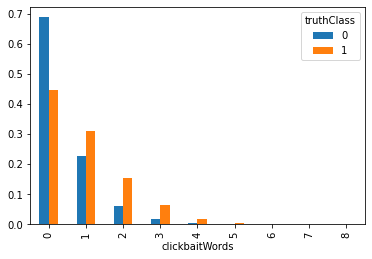

In [35]:
import matplotlib.pyplot as plt
df1 = dataset.groupby('clickbaitWords')['truthClass'].value_counts().unstack()
df1 = df1.divide(df1.sum(axis=0), axis=1)
df1.plot(kind = 'bar', stacked = False)
plt.show()

In [38]:
numberCountlist = []
for index, row in dataset.iterrows(): 
    words = row["postText"].split()
    count = 0
    for word in words:
        if word.isnumeric():
            count += 1 
    numberCountlist.append(count)
dataset['numOfNumerics'] = numberCountlist
numOfNumerics = dataset[['numOfNumerics']].values
dataset['numOfNumericsNorm'] = min_max_scaler.fit_transform(numOfNumerics)
dataset.head()

,id,truthClass,postText,numOfPunctuation,numOfPunctuationNorm,stemmingPostText,clickbaitWords,clickbaitWordsNorm,numOfNumerics,numOfNumericsNorm
0,858462320779026433,0,uks response to modern slavery leaving victims...,1,0.066667,uk respons to modern slaveri leav victim desti...,0,0.000,0,0.000
1,858421020331560960,1,this is good,0,0.000000,thi is good,1,0.125,0,0.000
2,858368123753435136,0,the forgotten trump roast relive his brutal 20...,3,0.200000,the forgotten trump roast reliv hi brutal 2004...,0,0.000,1,0.125
3,858323428260139008,1,meet the happiest dog in the world,2,0.133333,meet the happiest dog in the world,0,0.000,0,0.000
4,858283602626347008,0,tokyos subway is shut down amid fears over an ...,1,0.066667,tokyo subway is shut down amid fear over an im...,0,0.000,0,0.000


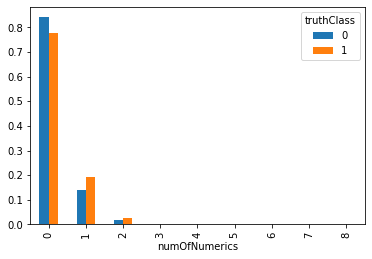

In [41]:
import matplotlib.pyplot as plt
df1 = dataset.groupby('numOfNumerics')['truthClass'].value_counts().unstack()
df1 = df1.divide(df1.sum(axis=0), axis=1)
df1.plot(kind = 'bar', stacked = False)
plt.show()

In [54]:
dataset = dataset.drop(['postText', 'truthClass', 'stemmingPostText'],axis=1)
dataset.head()

,id,numOfPunctuation,numOfPunctuationNorm,clickbaitWords,clickbaitWordsNorm,numOfNumerics,numOfNumericsNorm
0,858462320779026433,1,0.066667,0,0.000,0,0.000
1,858421020331560960,0,0.000000,1,0.125,0,0.000
2,858368123753435136,3,0.200000,0,0.000,1,0.125
3,858323428260139008,2,0.133333,0,0.000,0,0.000
4,858283602626347008,1,0.066667,0,0.000,0,0.000


In [55]:
#dataset.to_csv('export_dataframe.csv', index = False, header=True)